# Standalone Flow Matching code

In [27]:
import torch
from torch import nn,Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs,make_circles

\begin{aligned}
    \frac{d}{dt}X_t &= u_t(X_t)\\
\end{aligned}

In [5]:
class Flow(nn.Module):
    def __init__(self,dim:int=2,h:int=64):
        super().__init__()
        self.net=nn.Sequential(
        nn.Linear(dim+ 1,h),nn.ELU(),
        nn.Linear(h,h),nn.ELU(),
        nn.Linear(h,h),nn.ELU(),
        nn.Linear(h,dim))
    
    def forward(self,x_t:Tensor,t:Tensor)->Tensor:
        return self.net(torch.cat((t,x_t),-1))
    def step(self,x_t:Tensor,t_start:Tensor,t_end:Tensor)->Tensor:
        t_start=t_start.view(1, 1).expand(x_t.shape[0], 1)
        #Forsimplicity,usingmidpointODEsolverinthisexample
        return x_t+(t_end-t_start)* self(x_t+self(x_t,t_start)*(t_end-t_start)/2,
        t_start+(t_end-t_start)/2)

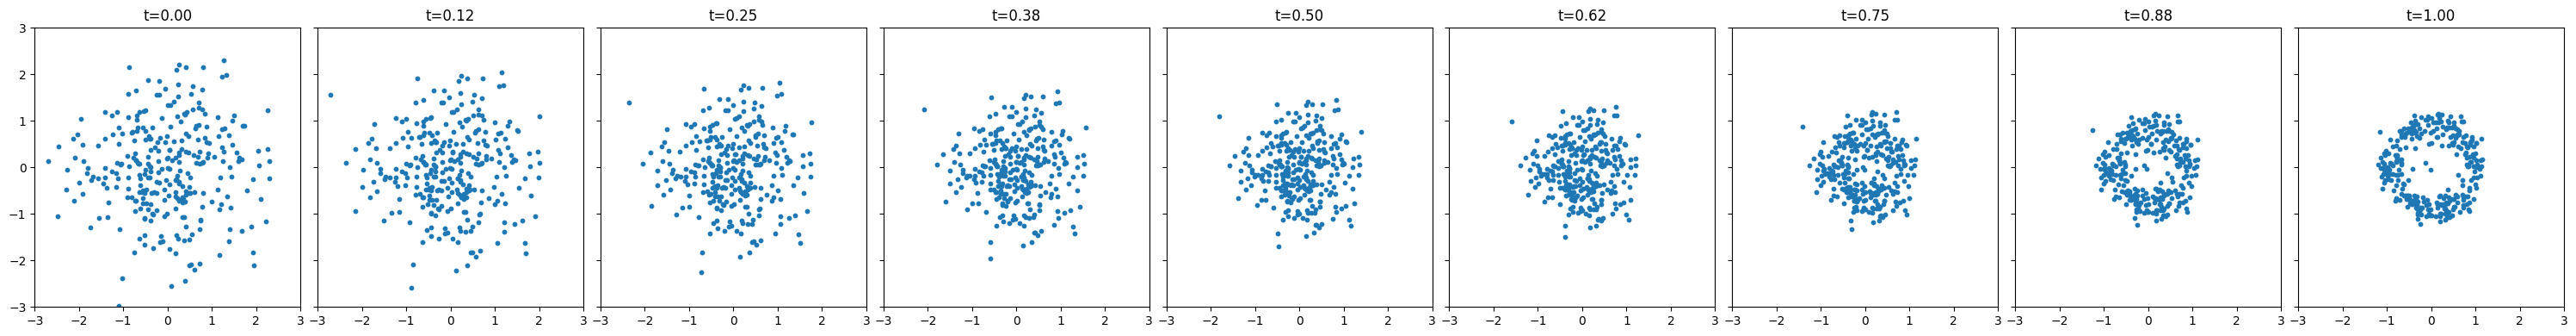

In [31]:
 #training
flow=Flow()
optimizer=torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn=nn.MSELoss()

for _ in range(10000):
    x_1 =Tensor(make_circles(n_samples=100, noise=0.1, random_state=42)[0])
    x_0 =torch.randn_like(x_1)
    t =torch.rand(len(x_1), 1)
    x_t =(1-t)*x_0+t*x_1
    dx_t=x_1-x_0
    optimizer.zero_grad()
    loss_fn(flow(x_t,t),dx_t).backward()
    optimizer.step()

#sampling
x=torch.randn(300,2)
n_steps=8
fig,axes=plt.subplots(1,n_steps+ 1,figsize=(30,4),sharex=True,sharey=True)
time_steps=torch.linspace(0, 1.0,n_steps+ 1)
axes[0].scatter(x.detach()[:,0],x.detach()[:, 1],s=10)
axes[0].set_title(f't={time_steps[0]:.2f}')
axes[0].set_xlim(-3.0,3.0)
axes[0].set_ylim(-3.0,3.0)
for i in range(n_steps):
    x=flow.step(x,time_steps[i],time_steps[i+ 1])
    axes[i+ 1].scatter(x.detach()[:,0],x.detach()[:, 1],s=10)
    axes[i+ 1].set_title(f't={time_steps[i+ 1]:.2f}')
plt.tight_layout()
plt.show()